In [1]:
import pickle
import subprocess
import sys
import nltk
from nltk import Nonterminal, nonterminals, Production, CFG

from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)

In [2]:
def get_parts(sentence):
    doc = Doc(sentence)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        print(token.text, token.pos)

In [3]:
get_parts('Чтобы быть успешным в современном мире нужно принимать его правила')

Чтобы SCONJ
быть AUX
успешным ADJ
в ADP
современном ADJ
мире NOUN
нужно ADJ
принимать VERB
его DET
правила NOUN


In [4]:
def tokenize(sentence):
    doc = Doc(sentence)
    doc.segment(segmenter)
    l = []
    for token in doc.tokens:
        l += [token.text]
    return l

In [5]:
def get_parts_of_speech(sentence):
    doc = Doc(sentence)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    
    parts_of_speech = {}
    l = []
    for token in doc.tokens:
        parts_of_speech[token.pos] = []
    for key in parts_of_speech:
        for token in doc.tokens:
            if key == token.pos:
                l += [token.text]
                parts_of_speech[key] = l
        l = []
    return parts_of_speech

In [6]:
# ADP - предлог - Prep
# ADJ - прилагательное - Adj
# ADV - наречие - Adv ()
# CCONJ - союз - C (и или но)
# SCONJ - простые союзы(чтобы, если, пока)
# AUX
# Pronoun - местоимение я ты он она
# PROPN - имя собственное (города имена и тд)
# PUNCT - пунктуации
# DET - определение местоимения (его ее)
# NUM - имя числительное - десять
# PART - частица - не 

In [16]:
def create_tree(sentence: str) -> CFG:
    grammar = """
    S -> S1 | S1 p S2 | S1 p C S2 | S1 p S2 p S3 | S1 p C S2 p S3
    S1 -> Adv | NP | VP | NP VP | NP VP C VP | NP AP
    S2 -> NP | VP | NP VP | NP VP C VP | NP AP
    S3 -> NP | VP | NP VP | NP VP C VP | NP AP
    VP -> V | V V | Adj V | V Aux | Aux V | VP NP | Adv VP | VP Adv | V PrepP | VP PrepP
    NP -> N | Pronoun | Num | PropN | Pronoun Aux | PropN Aux | NP NP | NP C NP | AP NP | NP Part | NP AP | Det NP | PrepP NP | SC NP
    PrepP -> Prep | Prep NP | Prep Det NP
    AP -> Adj | Adv Adj
    C -> CConj | SConj
    SC -> SConj | SConj Aux | SConj V
    """
    
    parts_of_speech = get_parts_of_speech(sentence)
    
    if 'VERB' in parts_of_speech:
        grammar += f"""
        V -> {' | '.join(f"'{w}'" for w in parts_of_speech["VERB"])}
        """
    if 'NOUN' in parts_of_speech:
        grammar += f"""
        N -> {' | '.join(f"'{w}'" for w in parts_of_speech["NOUN"])}
        """ 
    if 'PRON' in parts_of_speech:
        grammar += f"""
        Pronoun -> {' | '.join(f"'{w}'" for w in parts_of_speech["PRON"])}
        """
    if 'ADP' in parts_of_speech:
        grammar += f"""
        Prep -> {' | '.join(f"'{w}'" for w in parts_of_speech["ADP"])}
        """
    if 'ADV' in parts_of_speech:
        grammar += f"""
        Adv -> {' | '.join(f"'{w}'" for w in parts_of_speech["ADV"])}
        """
    if 'ADJ' in parts_of_speech:
        grammar += f"""
        Adj -> {' | '.join(f"'{w}'" for w in parts_of_speech["ADJ"])}
        """
    if 'CCONJ' in parts_of_speech:
        grammar += f"""
        CConj -> {' | '.join(f"'{w}'" for w in parts_of_speech["CCONJ"])}
        """
    if 'SCONJ' in parts_of_speech:
        grammar += f"""
        SConj -> {' | '.join(f"'{w}'" for w in parts_of_speech["SCONJ"])}
        """
    if 'NUM' in parts_of_speech:
        grammar += f"""
        Num -> {' | '.join(f"'{w}'" for w in parts_of_speech["NUM"])}
        """
    if 'PART' in parts_of_speech:
        grammar += f"""
        Part -> {' | '.join(f"'{w}'" for w in parts_of_speech["PART"])}
        """
    if 'PROPN' in parts_of_speech:
        grammar += f"""
        PropN -> {' | '.join(f"'{w}'" for w in parts_of_speech["PROPN"])}
        """
    if 'DET' in parts_of_speech:
        grammar += f"""
        Det -> {' | '.join(f"'{w}'" for w in parts_of_speech["DET"])}
        """
    if 'AUX' in parts_of_speech:
        grammar += f"""
        Aux -> {' | '.join(f"'{w}'" for w in parts_of_speech["AUX"])}
        """
    if 'PUNCT' in parts_of_speech:
        grammar += f"""
        p -> {' | '.join(f"'{w}'" for w in parts_of_speech["PUNCT"])}
        """
# ADP - предлог - Prep
# ADJ - прилагательное - Adj
# ADV - наречие - Adv ()
# CCONJ - союз - C (и или но)
# SCONJ - простые союзы(чтобы, если, пока) - C
# AUX
# PRON - местоимение я ты он она - Pronoun
# PROPN - имя собственное (города имена и тд) - PropN
# PUNCT - пунктуации
# DET - определение местоимения (его ее)
# NUM - имя числительное - десять - Num
# PART - частица - не - Part

    return CFG.fromstring(grammar)

In [7]:
sentence = 'я цветы люблю'
tokens = tokenize(sentence)
grammar = create_tree(sentence)
print(grammar.productions())

parser = nltk.ChartParser(grammar)
trees = list(parser.parse(tokens))
print(trees[0])

[S -> S1, S -> S1 p S2, S -> S1 p C S2, S -> S1 p S2 p S3, S -> S1 p C S2 p S3, S1 -> NP, S1 -> VP, S1 -> NP VP, S1 -> NP VP C VP, S1 -> NP AP, S2 -> NP, S2 -> VP, S2 -> NP VP, S2 -> NP VP C VP, S2 -> NP AP, S3 -> NP, S3 -> VP, S3 -> NP VP, S3 -> NP VP C VP, S3 -> NP AP, VP -> V, VP -> V V, VP -> Adj V, VP -> V Aux, VP -> VP NP, VP -> Adv VP, VP -> VP Adv, VP -> V PrepP, VP -> VP PrepP, NP -> N, NP -> Pronoun, NP -> Num, NP -> PropN, NP -> Pronoun Aux, NP -> PropN Aux, NP -> NP NP, NP -> AP NP, NP -> NP Part, NP -> NP AP, NP -> Det NP, NP -> PrepP NP, NP -> SC NP, PrepP -> Prep, PrepP -> Prep NP, PrepP -> Prep Det NP, AP -> Adj, AP -> Adv Adj, C -> CConj, C -> SConj, SC -> SConj, SC -> SConj Aux, SC -> SConj V, V -> 'люблю', N -> 'цветы', Pronoun -> 'я']
(S (S1 (NP (NP (Pronoun я)) (NP (N цветы))) (VP (V люблю))))


In [8]:
grammar.productions()

[S -> S1,
 S -> S1 p S2,
 S -> S1 p C S2,
 S -> S1 p S2 p S3,
 S -> S1 p C S2 p S3,
 S1 -> NP,
 S1 -> VP,
 S1 -> NP VP,
 S1 -> NP VP C VP,
 S1 -> NP AP,
 S2 -> NP,
 S2 -> VP,
 S2 -> NP VP,
 S2 -> NP VP C VP,
 S2 -> NP AP,
 S3 -> NP,
 S3 -> VP,
 S3 -> NP VP,
 S3 -> NP VP C VP,
 S3 -> NP AP,
 VP -> V,
 VP -> V V,
 VP -> Adj V,
 VP -> V Aux,
 VP -> VP NP,
 VP -> Adv VP,
 VP -> VP Adv,
 VP -> V PrepP,
 VP -> VP PrepP,
 NP -> N,
 NP -> Pronoun,
 NP -> Num,
 NP -> PropN,
 NP -> Pronoun Aux,
 NP -> PropN Aux,
 NP -> NP NP,
 NP -> AP NP,
 NP -> NP Part,
 NP -> NP AP,
 NP -> Det NP,
 NP -> PrepP NP,
 NP -> SC NP,
 PrepP -> Prep,
 PrepP -> Prep NP,
 PrepP -> Prep Det NP,
 AP -> Adj,
 AP -> Adv Adj,
 C -> CConj,
 C -> SConj,
 SC -> SConj,
 SC -> SConj Aux,
 SC -> SConj V,
 V -> 'люблю',
 N -> 'цветы',
 Pronoun -> 'я']

# MAIN

Сегодня, когда я кушала свой изысканный ужин из картошки и курицы, я увидела уведомление


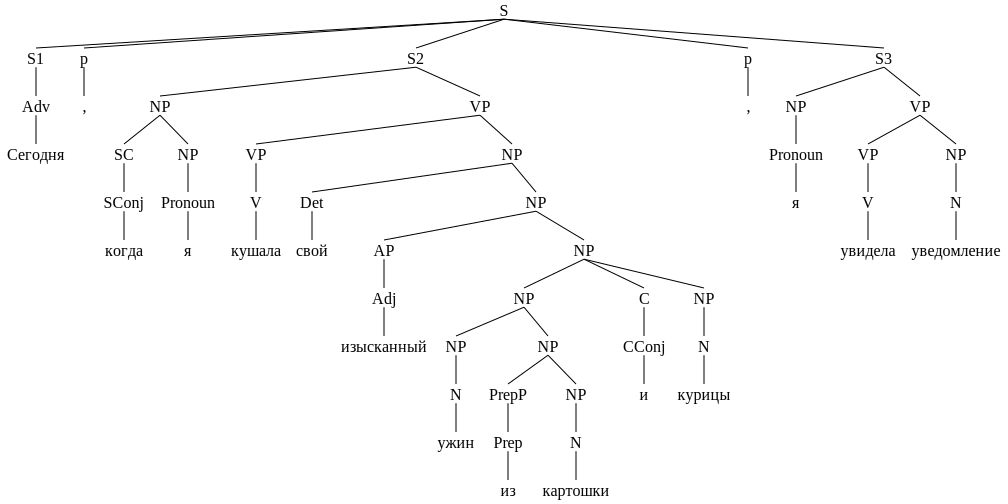

In [17]:
sentence = input()
tokens = tokenize(sentence)
tree = create_tree(sentence)
parser = nltk.ChartParser(tree)
trees = list(parser.parse(tokens))
trees[0]

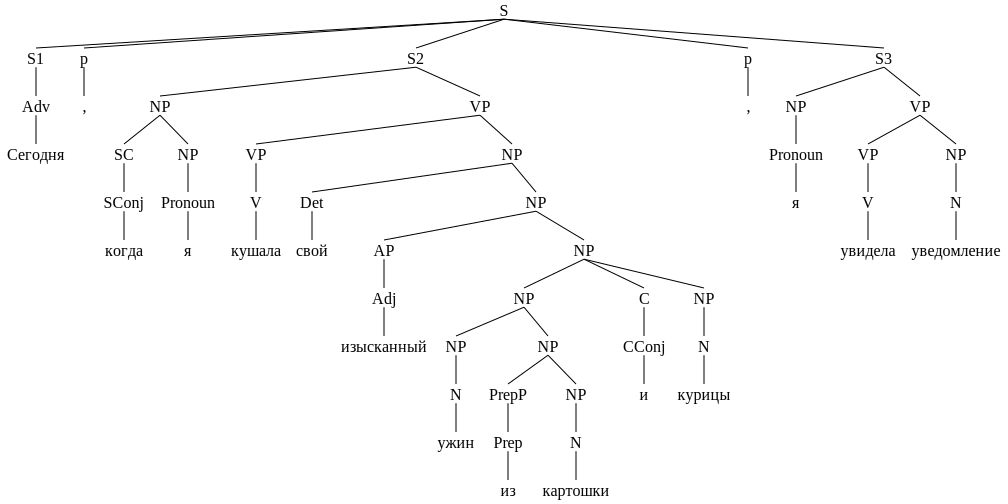

In [18]:
trees[0]

In [9]:
get_parts('Сегодня, когда я кушала свой изысканный ужин из картошки и курицы, я увидела уведомление')

Сегодня ADV
, PUNCT
когда SCONJ
я PRON
кушала VERB
свой DET
изысканный ADJ
ужин NOUN
из ADP
картошки NOUN
и CCONJ
курицы NOUN
, PUNCT
я PRON
увидела VERB
уведомление NOUN


In [35]:
Чтобы быть успешным в современном мире, нужно принимать его правила

SyntaxError: invalid syntax (Temp/ipykernel_18300/1183008672.py, line 1)

In [105]:
get_parts_of_speech('один')

if __name__ == '__main__':
    main()

{'NUM': ['один']}